In [1]:
from ray import tune
import os
import shutil
import time
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from ray.tune import JupyterNotebookReporter

%matplotlib inline
plt.style.use('dark_background')
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+notebook'

import sys
sys.path.insert(0, "../../")

from src.visualization import visualize

This is a general reference notebook to explore the use of ray tuner


# Very simple function to hypertune

Let's start with a basic function:
$$ f(x) = ax^3 + bx^2 + cx $$

In [2]:
import numpy as np


def model(x, config):
    return (
        config["a"] * np.sin(x**5)
        + config["b"] * np.cos(x**3)
        + config["c"] * (x**2)
    )


We now want to know: what are optimal values for $a$, $b$ and $c$ such that the
mean is minimized? Let's test
some values.

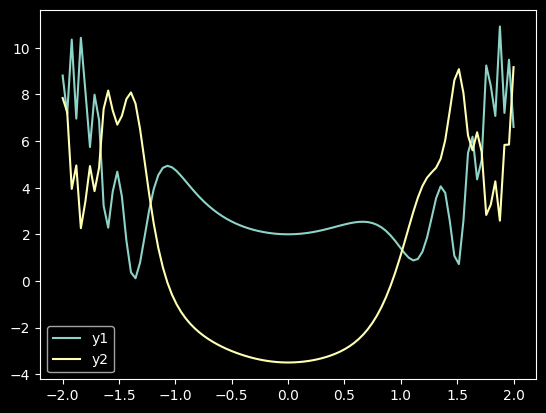

In [3]:
x = np.linspace(-2, 2, 100)
y1 = model(x, dict(a=-2, b=2, c=2))
y2 = model(x, dict(a=1.2, b=-3.5, c=2))
plt.plot(x, y1, label="y1")
plt.plot(x, y2, label="y2")
plt.legend()


In [4]:
y1.mean(), y2.mean()


(3.5629431534697993, 1.2463309629093344)

Now, let's try to hypertune this.

# Data

First, generate a 100 datapoints

In [5]:
# datapoints uniform on the domain [-2, 2]
data = np.random.uniform(-2, 2, 100)


# Train function and config

In [6]:
from typing import Dict


def train(config: Dict, seed: int = 42):
    total = 0
    np.random.seed(seed)
    np.random.shuffle(data)
    for epoch in range(100):
        loss = 0.0
        for i, x in enumerate(data):
            score = model(x, config)
            loss += score.mean()
        tune.report(iterations=epoch, mean_score=loss / (len(data)))


config = {"a": tune.uniform(-2, 2), "b": tune.uniform(-2, 2), "c": tune.uniform(-2, 2)}


We initialize a total score, and loop through the data.
For every observation $x$ we test the function, and keep track of the score.
The score is reported to `tune` with `tune.report`. We keep track of the
iterations and of the mean score.

Our config defines a uniform distribution for values of a, b and c

In [7]:
timer = {}
best_config = {}


# Random search

Now, let's do a random search. The reporter shows some output to keep track of.
The `tune.run` function runs the hypertuning. Our metric is the value of
`mean_score`, which is what we report in `tune.report`. We want to maximize this
value, so we tell tune to set `mode` to `"max"`.

We will take 40 samples, and stop training after 100 iterations for every sample.

In [8]:
from pathlib import Path

tune_dir = Path("../../models/ray/")
tune_dir.exists(), tune_dir.resolve()


(True, PosixPath('/Users/raoulgrouls/code/ML22/models/ray'))

In [9]:
reporter = JupyterNotebookReporter(overwrite=True)

tic = time.time()
analysis = tune.run(
    train,
    config=config,
    metric="mean_score",
    local_dir=tune_dir.resolve(),
    progress_reporter=reporter,
    mode="max",
    num_samples=40,
    stop={"training_iteration": 15},
    verbose=1,
)

timer["ray_random"] = time.time() - tic
best = analysis.get_best_config()
best["mean_score"] = analysis.best_result["mean_score"]
best_config["random"] = best


2022-12-05 17:47:39,548	INFO worker.py:1528 -- Started a local Ray instance.
2022-12-05 17:47:40,442	WARNING function_trainable.py:586 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-12-05 17:47:45,157	INFO tune.py:777 -- Total run time: 4.72 seconds (3.96 seconds for the tuning loop).


So, we searched the hyperparameter space. Problem is, these spaces can get
pretty big. If you have 10 hyperparameters, and every hyperparameter has 5
possible (relevant) values, you already have $5^{10}$ possible combinations, which is almost 10 million. Even if checking of every configuration would take just 1 second, it would take more than a 100 days to check them all...This
space can grow out of control pretty fast.

In [10]:
best

{'a': -0.1492642239325903,
 'b': 1.5237120965248256,
 'c': 1.9924263955625352,
 'mean_score': 3.1217842704340684}

# Resulting config

Now, lets run the objective with the best config.

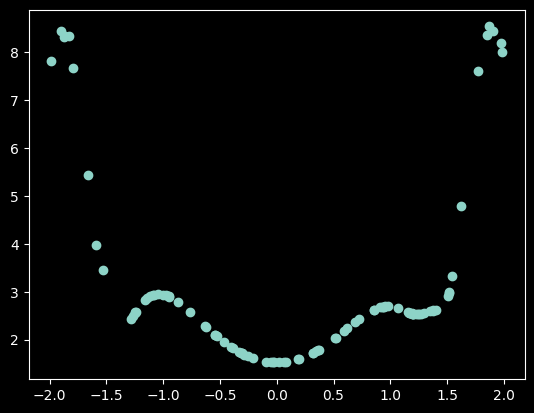

In [12]:
config = analysis.get_best_config()
y = model(data, config)
plt.scatter(data, y)


# config is sampled at random

And if we visualize the sampled hyperparameter space, we can clearly see it is
samples at random.

In [13]:
plot = analysis.results_df
plot.columns

Index(['iterations', 'mean_score', 'time_this_iter_s', 'done',
       'timesteps_total', 'episodes_total', 'training_iteration',
       'experiment_id', 'date', 'timestamp', 'time_total_s', 'pid', 'hostname',
       'node_ip', 'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore', 'warmup_time', 'experiment_tag', 'config/a',
       'config/b', 'config/c'],
      dtype='object')

In [15]:
import plotly.express as px

plot = analysis.results_df
select = ["config/a", "config/b", "config/c", "mean_score"]
p = plot[select].reset_index()
px.parallel_coordinates(p, color="mean_score")


/Users/raoulgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-wM7qE7ca-py3.9/lib/python3.9/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Note how the mean scores are sort of randomly distributed. This is a direct
effect of random guessing parameters.

# Bayes

Now, we improve the search algorithm with a bayesian optimization.

In [16]:
from ray.tune.search.bayesopt import BayesOptSearch

bayesopt = BayesOptSearch(random_search_steps=40)

config = {"a": tune.uniform(-2, 2), "b": tune.uniform(-2, 2), "c": tune.uniform(-2, 2)}

tic = time.time()
analysis = tune.run(
    train,
    config=config,
    metric="mean_score",
    mode="max",
    local_dir=tune_dir.resolve(),
    num_samples=40,
    progress_reporter=JupyterNotebookReporter(overwrite=True),
    stop={"training_iteration": 15},
    search_alg=bayesopt,
    verbose=2,
)

timer["ray_bayes"] = time.time() - tic

best = analysis.get_best_config()
best["mean_score"] = analysis.best_result["mean_score"]
best_config["bayes"] = best


2022-12-05 17:48:28,643	WARNING bayesopt_search.py:423 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2022-12-05 17:48:28,643	WARNING bayesopt_search.py:423 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2022-12-05 17:48:28,643	WARNING bayesopt_search.py:423 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.


Trial name,iterations,mean_score
train_a4d4f958,14,1.90412
train_a5dd03ae,14,-2.28967
train_a5dea18c,14,1.11281
train_a5dfaeb0,14,1.56445
train_a5e0ccdc,14,-2.07015
train_a5e1fc88,14,-0.194295
train_a5e34b7e,14,0.218095
train_a5e923a0,14,-1.00728
train_a5ebdabe,14,-1.03566
train_a5ef6350,14,-2.12062


2022-12-05 17:48:33,369	INFO tune.py:777 -- Total run time: 4.73 seconds (4.47 seconds for the tuning loop).


In [17]:
best

{'a': 1.1005312934444582,
 'b': 1.7579957662567565,
 'c': 1.5793094017105953,
 'mean_score': 2.697325397522687}

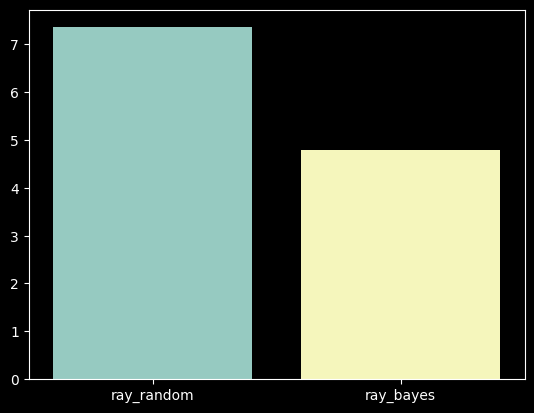

In [18]:
visualize.plot_timers(timer)


In [20]:
plot = analysis.results_df
select = ["config/a", "config/b", "config/c", "mean_score"]
p = plot[select].reset_index()
px.parallel_coordinates(p, color="mean_score")


/Users/raoulgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-wM7qE7ca-py3.9/lib/python3.9/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Not only is this slightly faster, you can also see that some scores are a bit more clustered.
. In addition to that, the result is more often a bit
better than random guesses.

In [21]:
import pandas as pd

pd.DataFrame.from_dict(best_config, orient="index")


,a,b,c,mean_score
random,-0.149264,1.523712,1.992426,3.121784
bayes,1.100531,1.757996,1.579309,2.697325


# Hyperband

Hyperband aborts runs early. Configs that are unpromising are abandoned before they complete.

In [22]:
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune import JupyterNotebookReporter

scheduler = AsyncHyperBandScheduler(
    time_attr="training_iteration", grace_period=1, reduction_factor=4, max_t=15
)

config = {"a": tune.uniform(-2, 2), "b": tune.uniform(-2, 2), "c": tune.uniform(-2, 2)}

tic = time.time()
analysis = tune.run(
    train,
    config=config,
    metric="mean_score",
    mode="max",
    local_dir=tune_dir.resolve(),
    num_samples=40,
    progress_reporter=JupyterNotebookReporter(overwrite=True),
    stop={"training_iteration": 15},
    scheduler=scheduler,
    verbose=2,
)
timer["ray_hyperband"] = time.time() - tic

best = analysis.get_best_config()
best["mean_score"] = analysis.best_result["mean_score"]
best_config["hyperband"] = best


Trial name,iterations,mean_score
train_814a1_00000,14,-2.26159
train_814a1_00001,0,-0.662424
train_814a1_00002,14,2.49355
train_814a1_00003,0,0.733706
train_814a1_00004,0,0.533693
train_814a1_00005,0,-0.366825
train_814a1_00006,0,-1.98745
train_814a1_00007,0,-1.4585
train_814a1_00008,0,1.09039
train_814a1_00009,0,-1.2777


2022-12-05 17:54:42,950	INFO tune.py:777 -- Total run time: 4.45 seconds (4.17 seconds for the tuning loop).


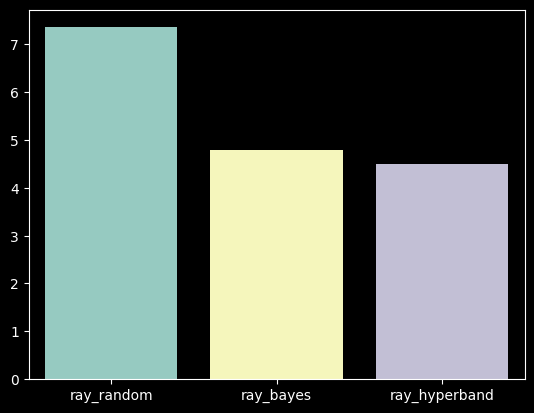

In [23]:
visualize.plot_timers(timer)


In [25]:
plot = analysis.results_df
select = ["config/a", "config/b", "config/c", "mean_score"]
p = plot[select].reset_index()
px.parallel_coordinates(p, color="mean_score")


/Users/raoulgrouls/Library/Caches/pypoetry/virtualenvs/deep-learning-wM7qE7ca-py3.9/lib/python3.9/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



(array([4., 3., 4., 5., 6., 3., 2., 5., 3., 5.]),
 array([-2.48793658, -1.95706954, -1.42620249, -0.89533544, -0.36446839,
         0.16639866,  0.6972657 ,  1.22813275,  1.7589998 ,  2.28986685,
         2.8207339 ]),
 <BarContainer object of 10 artists>)

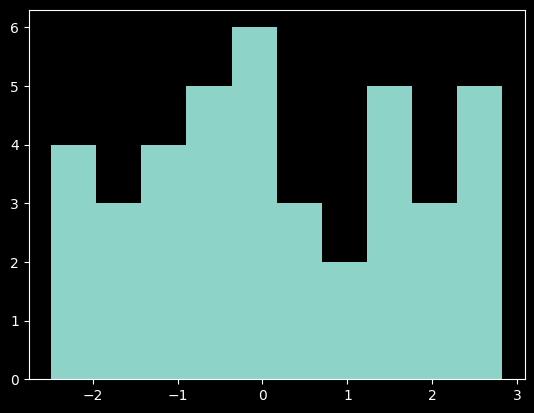

In [26]:
plt.hist(plot["mean_score"])


The result is better, too. You can see that there are more scores towards the maximum.
You can also see that only some (the best) have been run for the maximum amount of iterations.

ValueError: x and y must be the same size

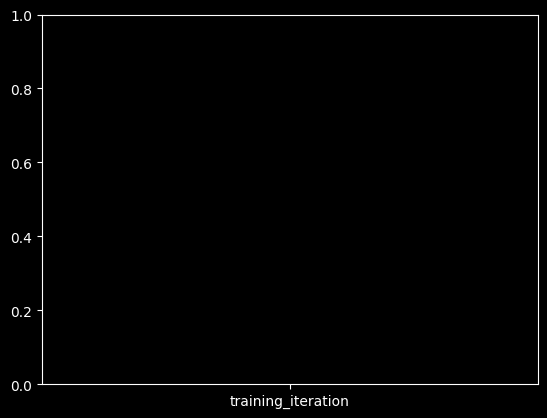

In [27]:
plt.scatter(data=p, x="training_iteration", y="mean_score")


In [28]:
pd.DataFrame.from_dict(best_config, orient="index")


,a,b,c,mean_score
random,-0.149264,1.523712,1.992426,3.121784
bayes,1.100531,1.757996,1.579309,2.697325
hyperband,-1.320637,1.219636,1.849352,2.820734


# Hyperbayes

In [29]:
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.suggest.bohb import TuneBOHB

bohb_hyperband = HyperBandForBOHB(
    time_attr="training_iteration",
    max_t=15,
    reduction_factor=4,
    stop_last_trials=False,
)


config = {"a": tune.uniform(-2, 2), "b": tune.uniform(-2, 2), "c": tune.uniform(-2, 2)}

bohb_search = TuneBOHB()

tic = time.time()
analysis = tune.run(
    train,
    config=config,
    metric="mean_score",
    mode="max",
    local_dir=tune_dir.resolve(),
    num_samples=40,
    progress_reporter=JupyterNotebookReporter(overwrite=True),
    stop={"training_iteration": 15},
    search_alg=bohb_search,
    scheduler=bohb_hyperband,
    verbose=2,
)
timer["ray_hyperbayes"] = time.time() - tic

best = analysis.get_best_config()
best["mean_score"] = analysis.best_result["mean_score"]
best_config["hyperbayes"] = best


/var/folders/80/8s5yj3pd3y1_r8kgp_nlz26c0000gn/T/ipykernel_15955/559507697.py:2: DeprecationWarning:

The module `ray.tune.suggest` has been moved to `ray.tune.search` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest` with `ray.tune.search`.

/var/folders/80/8s5yj3pd3y1_r8kgp_nlz26c0000gn/T/ipykernel_15955/559507697.py:2: DeprecationWarning:

The module `ray.tune.suggest.bohb` has been moved to `ray.tune.search.bohb` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest.bohb` with `ray.tune.search.bohb`.



AssertionError: HpBandSter must be installed!
            You can install HpBandSter with the command:
            `pip install hpbandster ConfigSpace`.

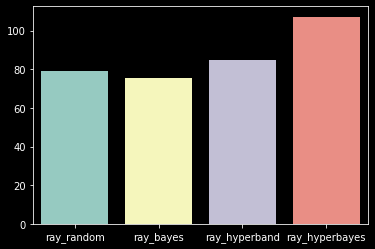

In [ ]:
visualize.plot_timers(timer)


In [ ]:
plot = analysis.results_df
select = ["config.a", "config.b", "config.c", "mean_score"]
p = plot[select].reset_index()
px.parallel_coordinates(p, color="mean_score")


In [ ]:
pd.DataFrame.from_dict(best_config, orient="index")


,a,b,c,mean_score
random,-1.427243,1.617216,1.328043,2.559240
bayes,1.100531,1.757996,1.579309,3.141262
hyperband,1.004512,1.989808,1.830999,3.598690
hyperbayes,1.891814,1.500398,1.973972,3.595479


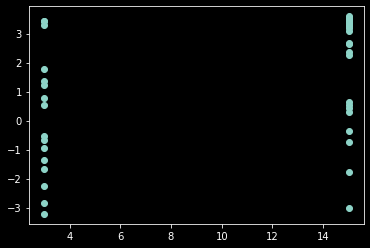

In [ ]:
p = analysis.results_df[["training_iteration", "mean_score"]]
plt.scatter(data=p, x="training_iteration", y="mean_score")


In [ ]:
DELETE = True
if DELETE:
    shutil.rmtree(tune_dir)
